First Steps: Guided Backpropagation

In [11]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
input_path = "C:/DL_Lab/Racoon_dataset/train/raccoon-20_jpg.rf.fb19aa368c074a61eed8829617ed6b7c.jpg"

(-0.5, 223.5, 223.5, -0.5)

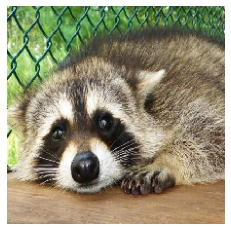

In [19]:
# load and import image with keras in RGB format
orig_image = load_img(input_path, target_size=(224,224))
image = img_to_array(orig_image) # scales to 0-255
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)
plt.imshow(orig_image)
plt.axis("off")

In [13]:
@tf.custom_gradient
def guided_RELU(x):
    # forward pass
    y = tf.nn.relu(x)
    # custom gradient: 
    def grad(dy):
        # is gradient > 0?
        grad_mask = tf.cast(dy > 0,"float32")
        # is fwd pass activation > 0
        act_mask = tf.cast(x > 0, "float32")
        return grad_mask * act_mask * dy
    return y, grad

In [14]:
# pretrained model
model = ResNet50(include_top=False, weights="imagenet")

(-0.5, 223.5, 223.5, -0.5)

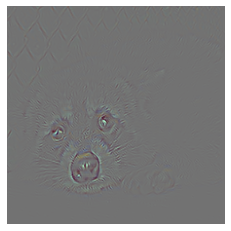

In [15]:
# go through all layers and replace relu with guided_relu
for layer in model.layers:
    if hasattr(layer, "activation"):
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guided_RELU

# get access to individual gradients
with tf.GradientTape() as tape:
  inputs = tf.cast(image, tf.float32)
  # ensures that tensor is being traced by this tape
  tape.watch(inputs)
  outputs = model(inputs)
# derive outputs by inputs
grads = tape.gradient(outputs, inputs)[0]

# scale to [0,1]
min = tf.math.reduce_min(grads)
max = tf.math.reduce_max(grads)
grads = (grads - min) / (max - min)
plt.imshow(grads)
plt.axis("off")

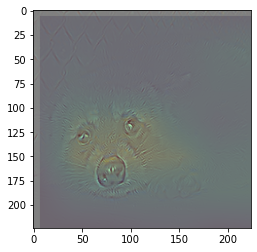

In [16]:
# # guided backprop enhanced and cam overlayed
# cam = tf.keras.utils.load_img("cam.png")
# plt.imshow(cam)
# plt.imshow(grads, alpha=0.9)

(-0.5, 223.5, 223.5, -0.5)

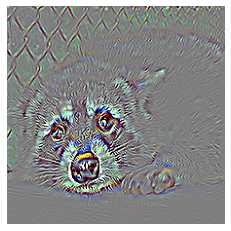

In [17]:
# this was copied from the keras repository, it enhances the picture
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

plt.imshow(deprocess_image(np.array(grads)))
plt.axis("off")

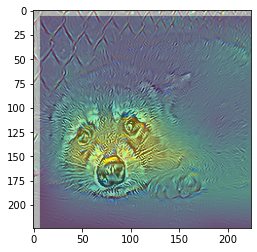

In [18]:
# # guided backprop enhanced and cam overlayed
# cam = tf.keras.utils.load_img("cam.png")
# plt.imshow(cam)
# plt.imshow(deprocess_image(np.array(grads)), alpha=0.6)